In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

In [7]:
# data prep
def gaussian_noise():
    return np.random.normal()


def ar_data_generator(init_seq, weights, noise_func, steps=500, normalize=True):
    """Generate AR(n) simulation data.

    Args:
        init_seq (np.array): Initial values to start with. An AR(n) process should have n initial values.
        weights (np.array): Weights on each prev time step and the noise term.
        noise_func (func): Calling this noise function gives a random term.
        steps (int): Length of the generated sequence.
    """
    init_steps = len(init_seq)
    sim_data = np.zeros(steps + init_steps)
    sim_data[:init_steps] = init_seq
    for i in range(steps):
        cur_val = 0
        for j in range(init_steps):
            cur_val += weights[j] * sim_data[i+j]
        cur_val += weights[-1] * noise_func()
        sim_data[i+init_steps] = cur_val
    sim_data = sim_data[init_steps:]
    if normalize:
        sim_data = (sim_data - np.mean(sim_data)) / np.std(sim_data)
    return sim_data


class SeqData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X[idx, :], self.y[idx])


def prepare_ts_ds(data, window_size, target_idx, train_size, val_size, test_size, batch_size):
    """Generate a time series dataset from simulation data.

    Args:
        data (np.array): Possible with F time series data of length N, in the shape of (N, F)
        target_idx (int): The index of the feature to be predicted.
        window_size (int)
        train_size (int)
        val_size (int)
        test_size (int)
    """
    data_len = len(data)
    train_xs, train_ys, test_xs, test_ys = [], [], [], []
    cur_test_num = 0
    for i in range(data_len):
        if i >= window_size:
            if i < (train_size + val_size) * 1.5:
                train_xs.append(data[i-window_size:i, :])
                train_ys.append(data[i, target_idx])
            elif cur_test_num < test_size:
                cur_test_num += 1
                test_xs.append(data[i-window_size:i, :])
                test_ys.append(data[i, target_idx])
            else:
                break
    train_xs = np.array(train_xs, dtype=np.float32)
    train_ys = np.array(train_ys, dtype=np.float32)
    test_xs = np.array(test_xs, dtype=np.float32)
    test_ys = np.array(test_ys, dtype=np.float32)
    dataset = SeqData(X=train_xs, y=train_ys)
    test_dataset = SeqData(X=test_xs, y=test_ys)
    train_dataset, val_dataset, _ = torch.utils.data.random_split(dataset, [train_size, val_size, len(dataset)-train_size-val_size])
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size ,shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_dataloader, val_dataloader, test_dataloader

[2.6001     2.62027    2.654509   ... 5.39712304 5.3975085  5.39789399]


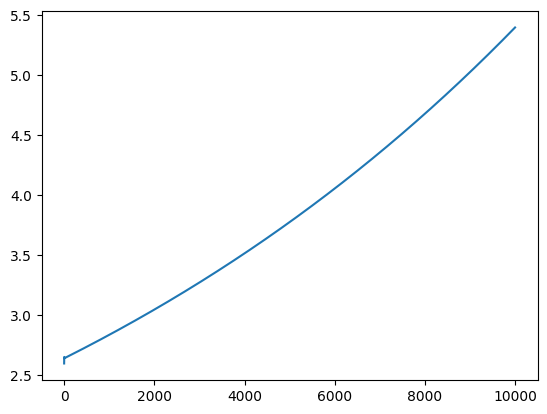

In [8]:
# simulation data
init_seq = np.array([1, 2, 3])
weights = np.array([0.1001, 0.2, 0.7, 0])
noise_func = gaussian_noise
steps = 10000
sim_data = ar_data_generator(init_seq, weights, noise_func, steps, normalize=False)
data = sim_data[100:, None]
print(sim_data)
plt.plot(sim_data[:])
plt.show()

# dataloader
train_dl, val_dl, test_dl = prepare_ts_ds(data, 3, 0, 2000, 500, 1000, 32)

In [9]:
# models
class FF(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim):
        super(FF, self).__init__()
        self.fc1 = nn.Linear(input_dim*seq_length, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.fc1 = nn.Linear(input_dim*seq_length, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # (batch size x seq length x input dim)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        # x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        # x = self.fc3(x)
        return x

In [10]:
model = FF(1, 3, 16)
learning_rate = 1e-4
device = torch.device('cuda:0')
epochs = 10

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    for batch in train_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        optimizer.zero_grad()
        loss.backward()
    model.eval()
    val_losses = []
    for batch in val_dl:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = loss_fn(y, y_pred)
        val_losses.append(loss.detach().cpu().numpy())
    print(f'val loss is {np.mean(val_losses)}')

val loss is 7.868220806121826
val loss is 7.857760429382324


/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20, 1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please e

val loss is 7.862363815307617
val loss is 7.864699363708496
val loss is 7.869464874267578
val loss is 7.8536696434021
val loss is 7.871915340423584
val loss is 7.884244441986084
val loss is 7.8614501953125
val loss is 7.847826957702637
